### ISyE524: Intro to Optimization
#### Problem Set #3
##### 1. MaxFlow
###### 1-1

The instance:

\begin{align*}
\text{Max} \quad & x_{ts} \\
\text{Subject to:} \quad & x_{s1} + x_{s2} - x_{ts} = 0 \\
\quad & - x_{s1} + x_{12} + x_{13} = 0 \\
\quad & - x_{s2} - x_{12} - x_{32} + x_{24} = 0 \\
\quad & - x_{13} + x_{32} + x_{3t} = 0 \\
\quad & - x_{24} + x_{4t} = 0 \\
\quad & - x_{3t} - x_{4t} + x_{ts} = 0 \\
\quad & 0 \leq x_{s1} \leq 6 \\
\quad & 0 \leq x_{s2} \leq 2 \\
\quad & 0 \leq x_{12} \leq 1 \\
\quad & 0 \leq x_{13} \leq 3 \\
\quad & 0 \leq x_{24} \leq 7 \\
\quad & 0 \leq x_{32} \leq 3 \\
\quad & 0 \leq x_{3t} \leq 2 \\
& 0 \leq x_{4t} \leq 7 \\
\end{align*}

The general model:

\begin{align*}
\text{Max} \quad & x_{ts} \\
\text{Subject to:} \quad & \sum_{j \in N} x_{ij} - \sum_{j \in N} x_{ji} = 0 \quad \forall i \in N, i \notin {s, t} \\
\quad & \sum_{j \in N} x_{sj} - \sum_{j \in N} x_{js} - x_{ts} = 0 \\
\quad & \sum_{j \in N} x_{tj} - \sum_{j \in N} x_{jt} + x_{ts} = 0 \\
& 0 \leq x_{ij} \leq u_{ij} \quad \forall (i, j) \in A 
\end{align*}

###### 1-2

The instance:

\begin{align*}
\text{Min} \quad & 6 \lambda_{s1} + 2 \lambda_{s2} + \lambda_{12} + 3 \lambda_{13} + 7 \lambda_{24} + 3 \lambda_{32} + 2 \lambda_{3t} + 7 \lambda_{4t}\\
\text{Subject to:} \quad & \mu_{s} - \mu_{1} + \lambda_{s1} \geq 0 \\
\quad & \mu_{s} - \mu_{2} + \lambda_{s2} \geq 0 \\
\quad & \mu_{1} - \mu_{2} + \lambda_{12} \geq 0 \\
\quad & \mu_{1} - \mu_{3} + \lambda_{13} \geq 0 \\
\quad & \mu_{2} - \mu_{4} + \lambda_{24} \geq 0 \\
\quad & \mu_{3} - \mu_{2} + \lambda_{32} \geq 0 \\
\quad & \mu_{3} - \mu_{t} + \lambda_{3t} \geq 0 \\
\quad & \mu_{4} - \mu_{t} + \lambda_{4t} \geq 0 \\
& -\mu_{s} + \mu_{t} \geq 1\\
& \mu_{i}   free \quad \forall i \in N \\
& 0 \leq \lambda_{ij} \quad \forall (i, j) \in A 
\end{align*}

The general model:

\begin{align*}
\text{Min} \quad & \sum_{(i,j) \in A} \mu_{ij} \lambda_{ij} \\
\text{Subject to:} \quad & \mu_{i} - \mu_{j} + \lambda_{ij} \geq 0 \quad \forall (i,j) \in A \\
& -\mu_{s} + \mu_{t} \geq 1\\
& \mu_{i}   free \quad \forall i \in N \\
& 0 \leq \lambda_{ij} \quad \forall (i, j) \in A 
\end{align*}

###### 1-3

In [14]:
using JuMP
using GLPK

# Create a new model with the GLPK solver
model = Model(GLPK.Optimizer)

# Define the variables for the flow on each arc
@variable(model, x[["s", "1", "2", "3", "4", "t"], ["s", "1", "2", "3", "4", "t"]] >= 0)

# Define the objective function to maximize the flow into t
@objective(model, Max, x["t","s"])

# Add capacity constraints
@constraint(model, x["s","1"] <= 6)
@constraint(model, x["s","2"] <= 2)
@constraint(model, x["1","2"] <= 1)
@constraint(model, x["1","3"] <= 3)
@constraint(model, x["3","2"] <= 3)
@constraint(model, x["2","4"] <= 7)
@constraint(model, x["3","t"] <= 2)
@constraint(model, x["4","t"] <= 7)

# Add flow conservation constraints
@constraint(model, x["s","1"] + x["s","2"] - x["t","s"] == 0)
@constraint(model, x["s","1"] - x["1","2"] - x["1","3"] == 0)
@constraint(model, x["s","2"] + x["1","2"] + x["3","2"] - x["2","4"] == 0)
@constraint(model, x["1","3"] - x["3","2"] - x["3","t"] == 0)
@constraint(model, x["2","4"] - x["4","t"] == 0)
@constraint(model, x["3","t"] + x["4","t"] - x["t","s"] == 0)

# Solve the model
optimize!(model)

# Output the results
println("The maximum flow from s to t is: ", objective_value(model))
value.(x)

The maximum flow from s to t is: 6.0


2-dimensional DenseAxisArray{Float64,2,...} with index sets:
    Dimension 1, ["s", "1", "2", "3", "4", "t"]
    Dimension 2, ["s", "1", "2", "3", "4", "t"]
And data, a 6×6 Matrix{Float64}:
 0.0  4.0  2.0  0.0  0.0  0.0
 0.0  0.0  1.0  3.0  0.0  0.0
 0.0  0.0  0.0  0.0  4.0  0.0
 0.0  0.0  1.0  0.0  0.0  2.0
 0.0  0.0  0.0  0.0  0.0  4.0
 6.0  0.0  0.0  0.0  0.0  0.0

###### 1-4

For every arc where the flow is positive and less than the capacity, 

the corresponding λ will be zero because the flow is not at the capacity limit.

\begin{align*}
\text{Min} \quad & 6 \lambda_{s1} + 2 \lambda_{s2} + \lambda_{12} + 3 \lambda_{13} + 7 \lambda_{24} + 3 \lambda_{32} + 2 \lambda_{3t} + 7 \lambda_{4t}\\
\text{Subject to:} \quad & \mu_{s} = 0 \\
\quad & \mu_{1} - \mu_{s} = 0 \\
\quad & \mu_{2} - \mu_{s} \geq \lambda_{s2} \\
\quad & \mu_{2} - \mu_{1} \geq \lambda_{12} \\
\quad & \mu_{3} - \mu_{1} \geq \lambda_{13} \\
\quad & \mu_{4} - \mu_{2} = 0 \\
\quad & \mu_{2} - \mu_{3} = 0 \\
\quad & \mu_{t} - \mu_{3} \geq \lambda_{3t} \\
\quad & \mu_{t} - \mu_{4} = 0 \\
& \mu_{t} = 1 \\
\end{align*}

Given the flow values and capacities, we have:

s→1: 4 (less than capacity)

s→2: 2 (at capacity)

1→2: 1 (at capacity)

1→3: 3 (at capacity)

3→2: 1 (less than capacity)

2→4: 4 (less than capacity)

3→t: 2 (at capacity)

4→t: 4 (less than capacity)

Thus,

\begin{align*}
\quad & \lambda_{s1} = \lambda_{24} = \lambda_{32} = \lambda_{3t} = \lambda_{4t} = 0 \\
\quad & \lambda_{s2} = \lambda_{12} = \lambda_{13} = 1 \\
\quad & \mu_{1} = \mu_{s} = 0 \\
\quad & \mu_{2} = \mu_{3} = \mu_{4} = \mu_{t} = 0 \\
& min(6 \lambda_{s1} + 2 \lambda_{s2} + \lambda_{12} + 3 \lambda_{13} + 7 \lambda_{24} + 3 \lambda_{32} + 2 \lambda_{3t} + 7 \lambda_{4t}) = 6
\end{align*}

Arcs where λ >0 are the arcs in the minimum cut. The arc s→2, 1→2, 1→3 form a minimum cut where the total flow equals the maximum flow of 6.

###### 1-5

Let S = {s, 1}, arcs in cut are (s, 2), (1, 2), (1, 3) form a minimum cut.

##### 2. Lasso
###### 2-1

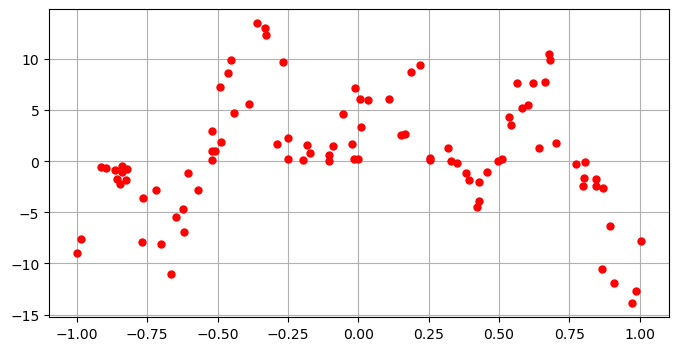

In [11]:
using PyPlot, CSV, DataFrames

data = CSV.read("lasso-data.csv", DataFrame)
x = data[:,1]
y = data[:,2]

cla()
figure(figsize=(8,4))
plot(x,y,"r.", markersize=10)
grid("True")
# Only need this in vscode?
display(gcf())

In [12]:
# Fit the data using a function of the form y = f(x) = u1 x^k + u2 x^(k-1) + ... + uk x + u{k+1}

# Order of polynomial used for fitting
k = 6

# Create the A matrix (where each row corresponds to one observation x_i and each column is an x^k term)
n = length(x)
A = zeros(n,k+1)
for i = 1:n
    for j = 1:k+1
        A[i,j] = x[i]^(k+1-j)
    end
end

# Solve the LEAST SQUARES polynomial fit

using JuMP, HiGHS
m6 = Model(HiGHS.Optimizer)

@variable(m6, u[1:k+1])
@objective(m6, Min, sum( (y - A*u).^2 ) )

optimize!(m6)
uopt6 = value.(u)
println(termination_status(m6))
println("The error is ", objective_value(m6))
println("The coefficients are ", uopt6)

Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Iteration, Runtime, ObjVal, NullspaceDim
0, 0.000520, 3073.967606, 7
3, 0.000748, 1607.360992, 7
Model   status      : Optimal
Objective value     :  1.6073609922e+03
HiGHS run time      :          0.00
OPTIMAL
The error is 1607.3609921595705
The coefficients are [-2.249371900396229, -41.30577606533521, -8.493550837855988, 43.82460620435696, -1.8469776466959757, -8.539113160802808, 3.375813786151018]


###### 2-2

In [13]:
# Fit the data using a function of the form y = f(x) = u1 x^k + u2 x^(k-1) + ... + uk x + u{k+1}

# Order of polynomial used for fitting
k = 18

# Create the A matrix (where each row corresponds to one observation x_i and each column is an x^k term)
n = length(x)
A = zeros(n,k+1)
for i = 1:n
    for j = 1:k+1
        A[i,j] = x[i]^(k+1-j)
    end
end

# Solve the LEAST SQUARES polynomial fit

using JuMP, HiGHS
m18 = Model(HiGHS.Optimizer)

@variable(m18, u[1:k+1])
@objective(m18, Min, sum( (y - A*u).^2 ) )

optimize!(m18)
uopt18 = value.(u)
println(termination_status(m18))
println("The error is ", objective_value(m18))
println("The coefficients are ", uopt18)

Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Iteration, Runtime, ObjVal, NullspaceDim
0, 0.000423, 3073.967606, 19
3, 0.000663, 522.039311, 19
Model   status      : Optimal
Objective value     :  5.2203999098e+02
HiGHS run time      :          0.00
OPTIMAL
The error is 522.0399909810724
The coefficients are [-85777.96987569737, -34190.35284858116, 391618.11446229444, 145410.400856986, -743933.078416506, -248442.9827777201, 761790.0455611285, 214415.78339220045, -455126.1937070716, -93662.63157967123, 160101.09152807322, 15385.569783950783, -31648.88748634598, 1765.1586151727297, 3070.4161891439185, -713.8251991827888, -106.44740057256564, 33.180843520283986, 3.92627202618853]


###### 2-3

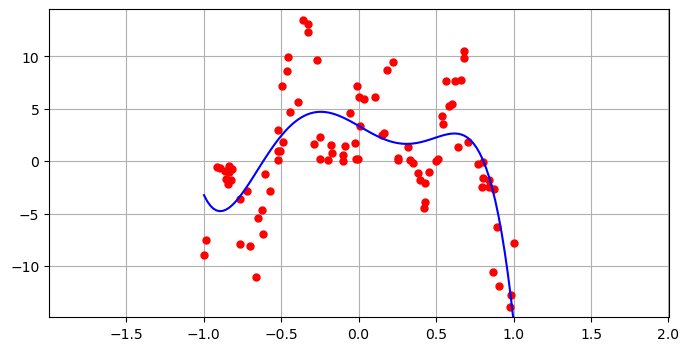

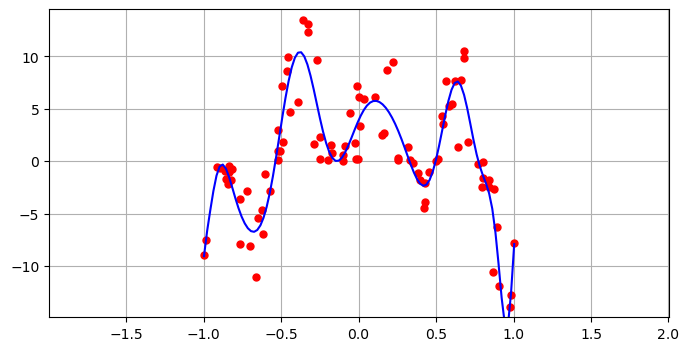

In [14]:
using PyPlot, LinearAlgebra
function plotwregsol(x,y,usol)

    minx = minimum(x)
    maxx = maximum(x)
    miny = minimum(y)
    maxy = maximum(y)   

    # Make (npts,k+1) matrix containing polynomial term values at plot points.  Fancy matrix stuff.
    npts = 100
    xfine = range(minx,stop=maxx,length=npts)
    ffine = ones(npts)
    for j = 1:k
        ffine = [ffine.*xfine ones(npts)]
    end

    # Compute the estimate values
    yfine = ffine * usol

    # Plot 'em
    figure(figsize=(8,4))
    plot(x,y,"r.", markersize=10)
    plot( xfine, yfine, "b-")

    axis([minx-1,maxx+1,miny-1,maxy+1])

    grid()
    display(gcf())
end
k = 6
plotwregsol(x,y,uopt6)
k = 18
plotwregsol(x,y,uopt18)

###### 2-4

lmda: 5.188318831883188
square error: 1750.7288345239217
final coefficients: [-3.133950058865113e-9, 0.5122948165244287, -6.640747717814536e-9, 4.896443891509967e-10, -2.364454198097784e-8, 6.786163170968674e-11, -5.078750776344198e-5, -2.3532064104009057e-10, -4.119148875733675e-8, -1.3755252566379357e-9, -1.0502491932457184e-8, -8.60620998721771, -7.281226720063096e-9, -3.349040714972334e-10, -11.86040155906339, 4.799541390716517, -0.421343221954695, -1.3013117768556085e-10, 3.2200742004906675]
18


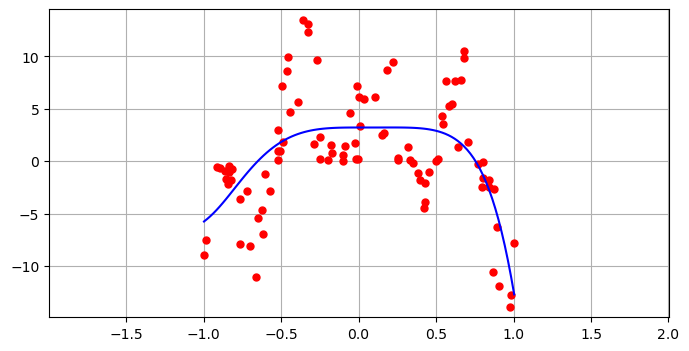

In [18]:
using Ipopt

function plotwregsol(x,y,usol, k)

    minx = minimum(x)
    maxx = maximum(x)
    miny = minimum(y)
    maxy = maximum(y)   

    # Make (npts,k+1) matrix containing polynomial term values at plot points.  Fancy matrix stuff.
    npts = 100
    xfine = range(minx,stop=maxx,length=npts)
    ffine = ones(npts)
    for j = 1:k
        ffine = [ffine.*xfine ones(npts)]
    end

    # Compute the estimate values
    println(k)
    yfine = ffine * usol

    # Plot 'em
    figure(figsize=(8,4))
    plot(x,y,"r.", markersize=10)
    plot( xfine, yfine, "b-")

    axis([minx-1,maxx+1,miny-1,maxy+1])
    grid("True")
    display(gcf())
end

function SQ(lmda, k)
    # Create the A matrix (where each row corresponds to one observation x_i and each column is an x^k term)
    n = length(x)
    A = zeros(n,k+1)
    for i = 1:n
        for j = 1:k+1
            A[i,j] = x[i]^(k+1-j)
        end
    end

    m_L2 = Model(Ipopt.Optimizer)
    set_silent(m_L2)
    @variable(m_L2, u[1:k+1]) # 0, 1, 2, 3, ... k

    @variable(m_L2, z[1:k+1])

    @constraint(m_L2, [i in 1:(k + 1)], z[i] >= u[i])
    @constraint(m_L2, [i in 1:(k + 1)], z[i] >= -u[i])

    @objective(m_L2, Min, sum( (y - A*u).^2 ) + lmda * sum(z[i] for i in 1:k+1) )

    optimize!(m_L2)
    uoptL2 = value.(u)
    # println(termination_status(m_L2))
    # println("The objective value is ", objective_value(m_L2))
    #println(uoptL2)

    positive_nums_count = sum(abs.(value.(u)) .> 1.0e-4)
    #println(positive_nums_count)
    error = sum((y - A * u).^2)
    return positive_nums_count, objective_value(m_L2), uoptL2, error
end

k = 18
list_lmda = range(5.15, stop=10, length=10000)
final_lmda=-9999
final_error=-9999
final_u_value=-9999
for i in list_lmda
    # println(i)
    positive_nums_count, obj_value, u_value, error = SQ(i, k)
    # println("positive_nums_count=", positive_nums_count)
    if positive_nums_count <=6
        global final_lmda=i
        global final_error=error
        global final_u_value=u_value
        break
    end
end


println("lmda: ", final_lmda)
println("square error: ", value.(final_error))
println("final coefficients: ", value.(final_u_value))
plotwregsol(x,y,final_u_value, k)

##### 3. Beam Me Up
###### 3-1

\begin{align*}
\text{Max} \quad & \sum_{r \in T} \tau_{r} - \lambda \sum_{r \in N} \Delta_{r} \\
\text{Subject to:} \quad & \tau_{r} = \sum_{b \in B} a_{br} x_{b}  \quad \forall r \in T \\
\quad & 0 \leq \Delta_{r} \quad \forall r \in N \\
\quad & \sum_{b \in B} (a_{br} x_{b} - p_{r}) \leq \Delta_{r} \quad \forall r \in N \\
& 0 \leq x_{b} \leq W_{b} \quad \forall b \in B 
\end{align*}

###### 3-2

In [1]:
using JuMP
using Ipopt

function solveOpt(λ)
  # Model
  model = Model(Ipopt.Optimizer)

  # Data
  beam_intensity = [
    15 7 8 12 12 6;
    13 4 12 19 15 14;
    9 8 13 13 10 17;
    4 12 12 6 18 16;
    9 4 11 13 6 14;
    8 7 7 10 10 10
  ]

  W_b = 3  # Maximum weight for each beam
  pr = 65  # Upper bound of the dose for normal regions

  # Decision variables
  @variable(model, x[1:6] >= 0)

  # Objective function
  @objective(model, Max, sum(x .* beam_intensity[:, 4:6]) - λ * sum(max.(0, sum(x .* beam_intensity[:, 1:3]) - pr)))

  # Constraints
  for i in 1:6
    @constraint(model, x[i] <= W_b)
  end

  # Solving the model
  set_silent(model)
  optimize!(model)

  return value.(x), sum(value.(x) .* sum(beam_intensity[:, 4:6], dims=1)), sum(max.(0, sum(value.(x) .* beam_intensity[:, 1:3], dims=1) .- pr))
end

x, T, N = solveOpt(1)
println("Total tumor dose: ", T)
println("Total normal tissue dose: ", N)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Total tumor dose: 3336.3558114953257
Total normal tissue dose: 206.89898190546643


###### 3-3

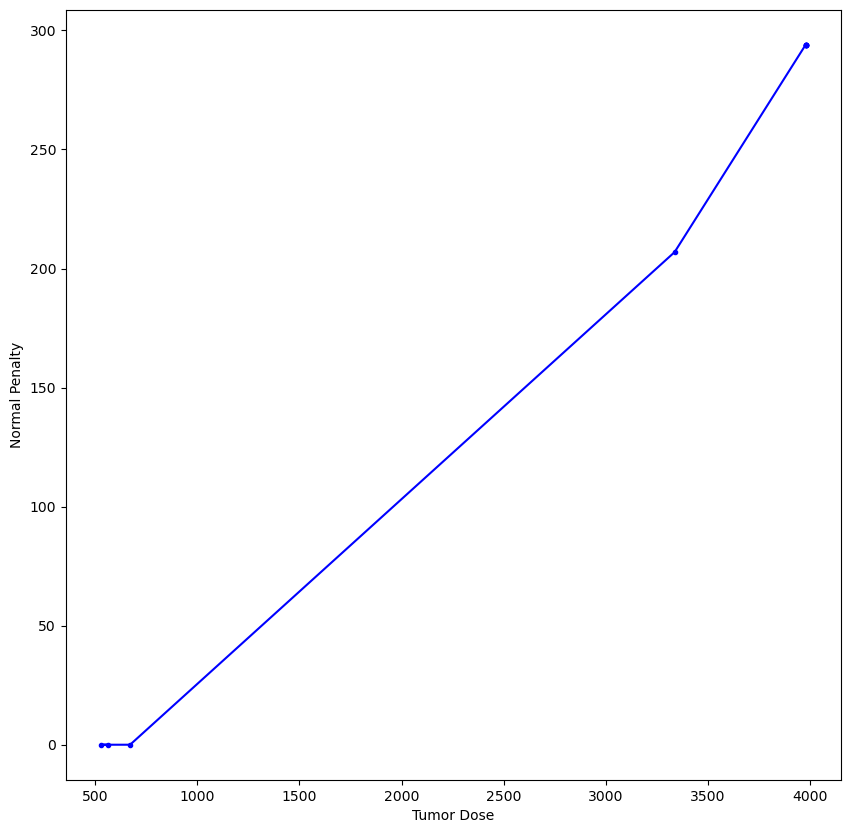

In [10]:
using PyPlot

λ_values = [i for i in 10 .^(range(-4, stop=2, length=10))]  
results = [(λ, solveOpt(λ)) for λ in λ_values]

function paretoPlot(x,y)
    figure(figsize=(10,10))
    plot( x, y, "b.-", markersize=6 )
    xlabel("Tumor Dose")
    ylabel("Normal Penalty")
    # Only need this in vscode?
    display(gcf())
end
;
T_values = [result[2][2] for result in results]
N_values = [result[2][3] for result in results]
paretoPlot(T_values, N_values)
# results

##### 4. Nonconvex QP
###### 4-1

In [63]:
using LinearAlgebra

Q = [
    0  0 -2 -4  0  1;
    0  1 -1 -1  3 -4;
   -2 -1 -1 -5  7 -4;
   -4 -1 -5 -3  7 -2;
    0  3  7  7 -1 -2;
    1 -4 -4 -2 -2  0
]
eigenvalues = eigen(Q).values
eigenvectors = eigen(Q).vectors
eigen(Q)

Eigen{Float64, Float64, Matrix{Float64}, Vector{Float64}}
values:
6-element Vector{Float64}:
 -16.119094460644884
  -3.756648129364134
  -0.5922928569671964
   2.2331144580905455
   3.845741541835814
  10.389179447049864
vectors:
6×6 Matrix{Float64}:
 -0.198724  -0.344542   0.738114    0.2365      0.432512   0.232352
 -0.197556   0.483214  -0.0898227   0.758158    0.204959  -0.320306
 -0.522407   0.129558  -0.0555954  -0.537552    0.483022  -0.430049
 -0.582895  -0.202886   0.218806    0.0794594  -0.701825  -0.268928
  0.528041   0.198591   0.537884   -0.146579   -0.11575   -0.59794
 -0.173138   0.741895   0.326854   -0.229135   -0.177927   0.478142

###### 4-2

In [87]:
using HiGHS, JuMP

c = [-1, 0, 2, -2, 4, 0]

model = Model(HiGHS.Optimizer)

# Define the decision variables with box constraints
@variable(model, 0 <= x[1:6] <= 1)

# Define the objective function
@objective(model, Min, x' * Q * x + c' * x)

# Attempt to solve the model
optimize!(model)

Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
ERROR:   Hessian has 3 diagonal entries in [-6, 0) so is not positive semidefinite for minimization
ERROR:   Cannot solve non-convex QP problems with HiGHS
Model   status      : Not Set
HiGHS run time      :          0.00


###### 4-3

In [89]:
eigen(Q - eigenvalues[1] * I)

Eigen{Float64, Float64, Matrix{Float64}, Vector{Float64}}
values:
6-element Vector{Float64}:
 -1.4210854715202004e-14
 12.36244633128075
 15.526801603677686
 18.35220891873542
 19.964836002480677
 26.508273907694758
vectors:
6×6 Matrix{Float64}:
 -0.198724  -0.344542   0.738114    0.2365      0.432512   0.232352
 -0.197556   0.483214  -0.0898227   0.758158    0.204959  -0.320306
 -0.522407   0.129558  -0.0555954  -0.537552    0.483022  -0.430049
 -0.582895  -0.202886   0.218806    0.0794594  -0.701825  -0.268928
  0.528041   0.198591   0.537884   -0.146579   -0.11575   -0.59794
 -0.173138   0.741895   0.326854   -0.229135   -0.177927   0.478142

###### 4-4

In [91]:
using HiGHS, JuMP

c = [-1, 0, 2, -2, 4, 0]

model = Model(HiGHS.Optimizer)

# Define the decision variables with box constraints
@variable(model, 0 <= x[1:6] <= 1)

# Define the objective function
@objective(model, Min, x' * (Q - eigen(Q).values[1] * I) * x + c' * x)

# Attempt to solve the model
optimize!(model)
x_k = value.(x)
println("Solution: ", x_k)

Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Iteration, Runtime, ObjVal, NullspaceDim
0, 0.000405, 0.000000, 0
9, 0.000578, -0.121812, 4
Model   status      : Optimal
Objective value     : -1.2181234180e-01
HiGHS run time      :          0.00
Solution: [0.053804198404868005, 0.007970204650426211, 0.0, 0.09485606161023015, 0.0, 0.010402593139239085]


##### 5. Pod Racing Rendezvous
###### 5-1

In [5]:
using JuMP, HiGHS

m = Model(HiGHS.Optimizer) 

@variable(m, x_a[1:2,1:60])  # position at each time
@variable(m, v_a[1:2,1:60])  # velocity at each time
@variable(m, u_a[1:2,1:60])  # thruster input at each time
@variable(m, x_p[1:2,1:60])  # position at each time
@variable(m, v_p[1:2,1:60])  # velocity at each time
@variable(m, u_p[1:2,1:60])  # thruster input at each time
# satisfy the dynamics (with zero initial velocity)
# Note the use of '.' form of constraints, to make the constraints hold for each component of the vector 

@constraint(m, v_a[:,1] .== [0;20])
@constraint(m, x_a[:,1] .== [0;0])
@constraint(m, v_p[:,1] .== [30;0])
@constraint(m, x_p[:,1] .== [0.5;0])
# model system dynamics
for t in 1:59
    @constraint(m, x_a[:,t+1] .== x_a[:,t] + v_a[:,t]/3600)
    @constraint(m, v_a[:,t+1] .== v_a[:,t] + u_a[:,t])
    @constraint(m, x_p[:,t+1] .== x_p[:,t] + v_p[:,t]/3600)
    @constraint(m, v_p[:,t+1] .== v_p[:,t] + u_p[:,t])
end

# hit all the checkpoints
@constraint(m, x_a[:,60] .== x_p[:,60])

# minimize 2-norm (squared) of acceleration
@objective(m, Min, sum(u_a.^2)+sum(u_p.^2))
optimize!(m)
println("The minimum energy is ", round(objective_value(m),digits=4))
value.(x_a[:,60])

Running HiGHS 1.7.0 (git hash: 50670fd4c): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [3e-04, 1e+00]
  Cost   [0e+00, 0e+00]
  Bound  [0e+00, 0e+00]
  RHS    [5e-01, 3e+01]
Iteration, Runtime, ObjVal, NullspaceDim
0, 0.002142, 6810500.508055, 238
100, 0.019016, 105.935392, 238
200, 0.030531, 105.935392, 238
300, 0.042226, 105.935392, 238
400, 0.054188, 105.935392, 238
483, 0.064442, 105.935392, 238
Model   status      : Optimal
Objective value     :  1.0593070491e+02
HiGHS run time      :          0.06
The minimum energy is 105.9307


2-element Vector{Float64}:
 0.4958190733923701
 0.1638793832719761

###### 5-2

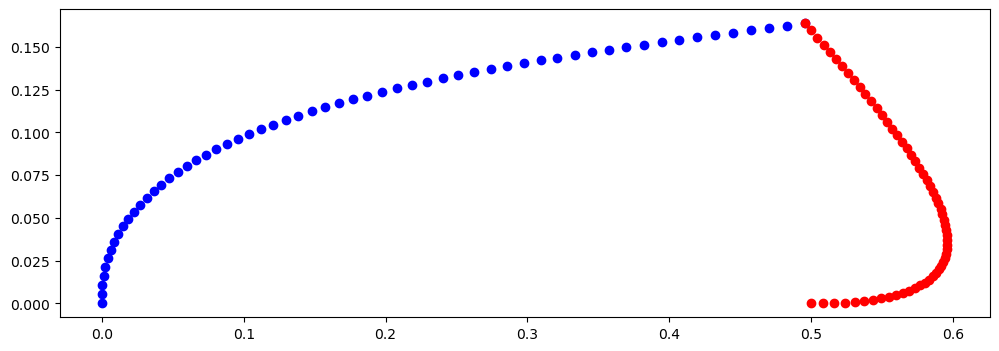

In [6]:
a_opt = value.(x_a)
p_opt = value.(x_p)
# plot the solution against the checkpoints
using PyPlot
figure(figsize=(12,4))
plot( a_opt[1,:], a_opt[2,:], "b.", markersize=12 )
plot( p_opt[1,:], p_opt[2,:], "r.", markersize=12 )
# Only need this in vscode?
display(gcf())

###### 5-3

In [7]:
using JuMP, HiGHS

m = Model(HiGHS.Optimizer) 

@variable(m, x_a[1:2,1:60])  # position at each time
@variable(m, v_a[1:2,1:60])  # velocity at each time
@variable(m, u_a[1:2,1:60])  # thruster input at each time
@variable(m, x_p[1:2,1:60])  # position at each time
@variable(m, v_p[1:2,1:60])  # velocity at each time
@variable(m, u_p[1:2,1:60])  # thruster input at each time
# satisfy the dynamics (with zero initial velocity)
# Note the use of '.' form of constraints, to make the constraints hold for each component of the vector 

@constraint(m, v_a[:,1] .== [0;20])
@constraint(m, x_a[:,1] .== [0;0])
@constraint(m, v_p[:,1] .== [30;0])
@constraint(m, x_p[:,1] .== [0.5;0])
# model system dynamics
for t in 1:59
    @constraint(m, x_a[:,t+1] .== x_a[:,t] + v_a[:,t]/3600)
    @constraint(m, v_a[:,t+1] .== v_a[:,t] + u_a[:,t])
    @constraint(m, x_p[:,t+1] .== x_p[:,t] + v_p[:,t]/3600)
    @constraint(m, v_p[:,t+1] .== v_p[:,t] + u_p[:,t])
end

# hit all the checkpoints
@constraint(m, x_a[:,60] .== x_p[:,60])
# final velocity equal to zero
@constraint(m, v_a[:,60] .== [0;0])
@constraint(m, v_p[:,60] .== [0;0])

# minimize 2-norm (squared) of acceleration
@objective(m, Min, sum(u_a.^2)+sum(u_p.^2))
optimize!(m)
value.(x_a[:,60])

Running HiGHS 1.7.0 (git hash: 50670fd4c): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [3e-04, 1e+00]
  Cost   [0e+00, 0e+00]
  Bound  [0e+00, 0e+00]
  RHS    [5e-01, 3e+01]
Iteration, Runtime, ObjVal, NullspaceDim
0, 0.002439, 6810500.508055, 234
100, 0.022539, 245.590267, 234
200, 0.034929, 245.590267, 234
300, 0.046880, 245.590267, 234
400, 0.058999, 245.590267, 234
435, 0.063327, 245.590267, 234
Model   status      : Optimal
Objective value     :  2.4558737581e+02
HiGHS run time      :          0.06


2-element Vector{Float64}:
 0.37499821699866076
 0.08333214500989078

###### 5-4

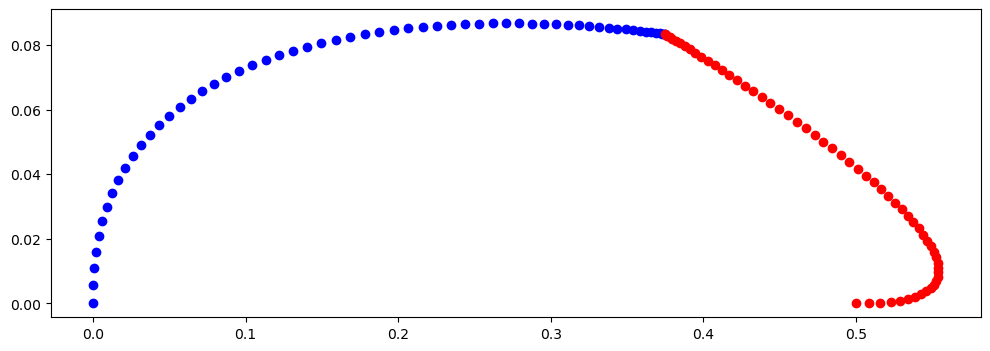

In [8]:
a_opt = value.(x_a)
p_opt = value.(x_p)
# plot the solution against the checkpoints
using PyPlot
figure(figsize=(12,4))
plot( a_opt[1,:], a_opt[2,:], "b.", markersize=12 )
plot( p_opt[1,:], p_opt[2,:], "r.", markersize=12 )
# Only need this in vscode?
display(gcf())